In [1]:
## This is the implementation of a 2 degree of manipulator
## Author: Avadesh Meduri
## Date : 22/06/2020

import numpy as np
from matplotlib import pyplot as plt

# these packages for animating the robot env
import IPython
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation

In [80]:
class TwoDOFManipulator:
    
    def __init__(self, l1, l2, m1, m2):
        
        self.dt = 0.001 # discretization step in seconds
        self.g = 9.81 # gravity vector
        
        self.l1 = l1
        self.l2 = l2
        
        self.m1 = m1
        self.m2 = m2
        
        self.Il1 = self.m1*(self.l1**2)/12.0 #inertia of link 1 around the center of mass axis
        self.Il2 = self.m2*(self.l2**2)/12.0 #inertia of link 2 around the center of mass axis
        
        self.Im1 = 4*self.Il1 #inertia of link 1 around the rotor axis
        self.Im2 = 4*self.Il2 #inertia of link 2 around the rotor axis
        
    def dynamics(self, th1, th2, thd1, thd2, tau1, tau2):
        '''
        This function computes the dynamics (dy/dt = f(y,t)) given the current state of the robot
        (Joint Position, Joint velocities, tau).
        Input:
            th1 : joint position of first link (closest to the base)
            th2 : joint position of second link
            thd1 : joint velocity of the first link
            thd2 : joint velocity of the second link
            tau1 : torque input to the first link
            tau2 : torque input to the second link
        '''
        xd = np.zeros(4)
        xd[0] = thd1
        xd[1] = thd2
        
        # defining the matrix A, b such that A * [thdd1, thdd2] = b. b is function of
        # tau and th1, th2, thd1, thd2
        
        A = np.zeros((2, 2))
        A[0,0] = self.Im1 + self.m2*self.l1**2 + self.Im2 + self.m2*self.l1*self.l2*np.cos(th2)
        A[0,1] = self.Im2 + self.m2*self.l1*self.l2*np.cos(th2)/2.0
        A[1,0] = self.Im2 + self.m2*self.l1*self.l2*np.cos(th2)/2.0
        A[1,1] = self.Im2
        
        b = np.zeros(2)
        b[0] = tau1 + self.m2*self.l1*self.l2*thd1*thd2*np.sin(th2) + \
                    self.m2*self.l1*self.l2*(thd2**2)*np.sin(th2)/2.0 - self.m2*self.l2*self.g*np.cos(th1+th2)/2.0 \
                    - (self.m1*self.l1/2.0 + self.m2*self.l1)*self.g*np.cos(th1)
        
        b[1] = tau2 - self.m2*self.l1*self.l2*(thd1**2)*np.sin(th2)/2.0 - self.m2*self.l2*self.g*np.cos(th1+th2)/2.0
        
        #computing inv
        A_inv = np.zeros((2,2))
        A_inv[0,0] = A[1, 1]
        A_inv[1,1] = A[0, 0]
        A_inv[0,1] = -A[0,1]
        A_inv[1,0] = -A[1,0]
        A_inv = (1/np.linalg.det(A))*A_inv
        
        xd[2:] = np.matmul(A_inv, b.T)
        
        return xd[0], xd[1], xd[2], xd[3]
    
    def integrate_dynamics_euler(self, th1_t, th2_t, thd1_t, thd2_t, tau1_t, tau2_t):
        '''
        This funciton integrates the dynamics for one time step using euler integration
        Input:
            th1_t : joint position of first link (closest to the base)
            th2_t : joint position of second link
            thd1_t : joint velocity of the first link
            thd2_t : joint velocity of the second link
            tau1_t : torque input to the first link
            tau2_t : torque input to the second link
        '''
        # computing joint velocities, joint acceleration
        jt_vel1, jt_vel2, jt_acc1, jt_acc2 = self.dynamics(th1_t, th2_t, thd1_t, thd2_t, tau1_t, tau2_t)
        # integrating using euler scheme
        th1_t_1 = th1_t + jt_vel1*self.dt
        th2_t_1 = th2_t + jt_vel2*self.dt
        thd1_t_1 = thd1_t + jt_acc1*self.dt
        thd2_t_1 = thd2_t + jt_acc2*self.dt
        
        return th1_t_1, th2_t_1, thd1_t_1, thd2_t_1
    
    def integrate_dynamics_runga_kutta(self, th1_t, th2_t, thd1_t, thd2_t, tau1_t, tau2_t):
        '''
        This funciton integrates the dynamics for one time step using runga kutta integration
        Input:
            th1_t : joint position of first link (closest to the base)
            th2_t : joint position of second link
            thd1_t : joint velocity of the first link
            thd2_t : joint velocity of the second link
            tau1_t : torque input to the first link
            tau2_t : torque input to the second link
        '''
        k1_jt_vel1, k1_jt_vel2, k1_jt_acc1, k1_jt_acc2 = self.dynamics(th1_t, th2_t, thd1_t, thd2_t, tau1_t, tau2_t)
        k2_jt_vel1, k2_jt_vel2, k2_jt_acc1, k2_jt_acc2 = \
            self.dynamics(th1_t + 0.5*self.dt*k1_jt_vel1, th2_t + 0.5*self.dt*k1_jt_vel2, thd1_t + 0.5*self.dt*k1_jt_acc1, thd2_t + 0.5*self.dt*k1_jt_acc2, tau1_t, tau2_t)
        k3_jt_vel1, k3_jt_vel2, k3_jt_acc1, k3_jt_acc2 = \
            self.dynamics(th1_t + 0.5*self.dt*k2_jt_vel1, th2_t + 0.5*self.dt*k2_jt_vel2, thd1_t + 0.5*self.dt*k2_jt_acc1, thd2_t + 0.5*self.dt*k2_jt_acc2, tau1_t, tau2_t)
        k4_jt_vel1, k4_jt_vel2, k4_jt_acc1, k4_jt_acc2 = \
            self.dynamics(th1_t + self.dt*k3_jt_vel1, th2_t + self.dt*k3_jt_vel2, thd1_t + self.dt*k3_jt_acc1, thd2_t + self.dt*k3_jt_acc2, tau1_t, tau2_t)
        
        th1_t_1 = th1_t + (1/6)*self.dt*(k1_jt_vel1 + 2*k2_jt_vel1 + 2*k3_jt_vel1 + k4_jt_vel1)
        th2_t_1 = th2_t + (1/6)*self.dt*(k1_jt_vel2 + 2*k2_jt_vel2 + 2*k3_jt_vel2 + k4_jt_vel2)
        thd1_t_1 = thd1_t + (1/6)*self.dt*(k1_jt_acc1 + 2*k2_jt_acc1 + 2*k3_jt_acc1 + k4_jt_acc1)
        thd2_t_1 = thd2_t + (1/6)*self.dt*(k1_jt_acc2 + 2*k2_jt_acc2 + 2*k3_jt_acc2 + k4_jt_acc2)
    
        return th1_t_1, th2_t_1, thd1_t_1, thd2_t_1
    
    
    def reset_manipulator(self, init_th1, init_th2, init_thd1, init_thd2):
        '''
        This function resets the manipulator to the initial position
        Input:
            init_th1 : initial joint position 1 (in degrees)
            init_th2 : initial joint position 2 (in degrees)
            init_thd1 : initial joint velocity 1
            init_thd2 : initial joint velocity 2
        '''
        # converting to radians
        init_th1 = (np.pi/180)*init_th1
        init_th2 = (np.pi/180)*init_th2
        
        # Creating an array to store the history of robot states as the dynamics are integrated
        # each row corresponds to one state just as in the case of the 1DOF env
        self.sim_data = np.array([[init_th1], [init_th2], [init_thd1], [init_thd2], [0.0], [0.0]])
        self.t = 0 # time counter in milli seconds

    def step_manipulator(self, tau1, tau2, use_euler = False):
        '''
        This function integrated dynamics using the input torques
        Input:
            tau1 : joint 1 torque
            tau2 : joint 2 torque
        '''
        
        self.sim_data[:,self.t][4:6] = [tau1, tau2]
        
        th1_t = self.sim_data[:,self.t][0]
        th2_t = self.sim_data[:,self.t][1]
        thd1_t = self.sim_data[:,self.t][2]
        thd2_t = self.sim_data[:,self.t][3]
        
        if use_euler:
            th1_t_1, th2_t_1, thd1_t_1, thd2_t_1 = \
                self.integrate_dynamics_euler(th1_t, th2_t, thd1_t, thd2_t, tau1, tau2)
        else:
            th1_t_1, th2_t_1, thd1_t_1, thd2_t_1 = \
                self.integrate_dynamics_runga_kutta(th1_t, th2_t, thd1_t, thd2_t, tau1, tau2)
    
    
        # making sure that joint positions lie within 0, 360
        th1_t_1 = np.sign(th1_t_1)*(np.abs(th1_t_1)%(2*np.pi))
        th2_t_1 = np.sign(th2_t_1)*(np.abs(th2_t_1)%(2*np.pi))
        
        sim_data_t_1 = np.array([[th1_t_1], [th2_t_1], [thd1_t_1], [thd2_t_1], [0.0], [0.0]])
        
        # adding the data to sim_data
        self.sim_data = np.concatenate((self.sim_data, sim_data_t_1), axis = 1)
        # incrementing time
        self.t += 1
        
    def get_joint_position(self):
        '''
        This function returns the current joint position (degrees) of the mainpulator
        '''
        return (180/np.pi)*self.sim_data[:,self.t][0], (180/np.pi)*self.sim_data[:,self.t][1] 
    
    def get_joint_velocity(self):
        '''
        This function returns the current joint velocity (degrees/sec) of the mainpulator
        '''
        return self.sim_data[:,self.t][2], self.sim_data[:,self.t][3] 
    
    def animate(self, freq = 25):
        
        sim_data = self.sim_data[:,::freq]

        fig = plt.figure()
        ax = plt.axes(xlim=(-self.l1 - self.l2 -1, self.l1 + self.l2 + 1), ylim=(-self.l1 - self.l2 -1, self.l1 + self.l2 + 1))
        text_str = "Two Dof Manipulator Animation"
        arm1, = ax.plot([], [], lw=4)
        arm2, = ax.plot([], [], lw=4)
        base, = ax.plot([], [], 'o', color='black')
        joint, = ax.plot([], [], 'o', color='green')
        hand, = ax.plot([], [], 'o', color='pink')
        
        def init():
            arm1.set_data([], [])
            arm2.set_data([], [])
            base.set_data([], [])
            joint.set_data([], [])
            hand.set_data([], [])
            
            return arm1, arm2, base, joint, hand
        
        def animate(i):
            theta1_t = sim_data[:,i][0]
            theta2_t = sim_data[:,i][1]
            
            joint_x = self.l1*np.cos(theta1_t)
            joint_y = self.l1*np.sin(theta1_t)
            
            hand_x = joint_x + self.l2*np.cos(theta1_t + theta2_t)
            hand_y = joint_y + self.l2*np.sin(theta1_t + theta2_t)
            
            base.set_data([0, 0])
            arm1.set_data([0,joint_x], [0,joint_y])
            joint.set_data([joint_x, joint_y])
            arm2.set_data([joint_x, hand_x], [joint_y, hand_y])
            hand.set_data([hand_x, hand_y])

            return base, arm1, joint, arm2, hand
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, text_str, transform=ax.transAxes, fontsize=15,
        verticalalignment='top', bbox=props)
        ax.grid()
        anim = FuncAnimation(fig, animate, init_func=init,
                                       frames=np.shape(sim_data)[1], interval=25, blit=True)

        plt.close(fig)
        plt.close(anim._fig)
        IPython.display.display_html(IPython.core.display.HTML(anim.to_html5_video()))

    def plot(self):
        '''
        This function plots the joint positions, velocities and torques
        '''
        
        fig, axs = plt.subplots(3,1, figsize = (10, 10))
        axs[0].plot((180/np.pi)*self.sim_data[0], label = 'joint position_1')
        axs[0].plot((180/np.pi)*self.sim_data[1], label = 'joint position_2')
        axs[0].grid()
        axs[0].legend()
        axs[0].set_ylabel("degrees")

        axs[1].plot(self.sim_data[2], label = 'joint velocity_1')
        axs[1].plot(self.sim_data[3], label = 'joint velocity_2')
        axs[1].grid()
        axs[1].legend()
        axs[1].set_ylabel("rad/sec")
    
        axs[2].plot(self.sim_data[4,:-1], label = 'torque_1')
        axs[2].plot(self.sim_data[5,:-1], label = 'torque_2')
        axs[2].grid()
        axs[2].legend()
        axs[2].set_ylabel("Newton/(Meter Second)")
    
        plt.show()
        

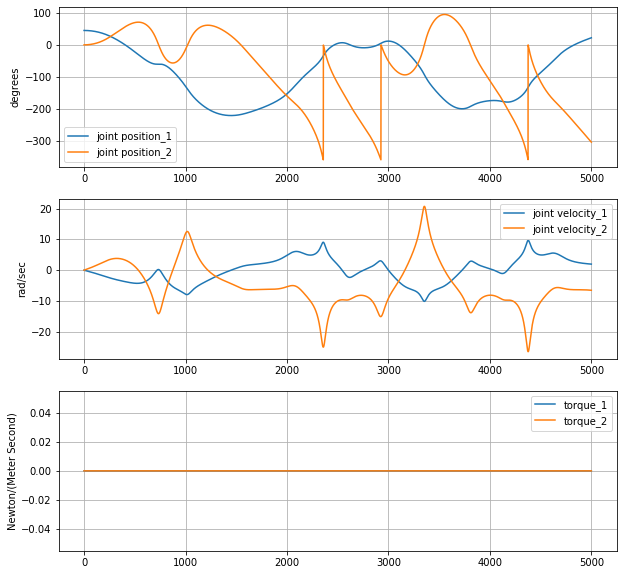

In [81]:
# simulation of Env
# env = TwoDOFManipulator(1, 1, 1, 1)
# env.reset_manipulator(45,0, 0, 0)

# horizon = 5000 # duration of simulation steps

# for t in range(horizon):
#     tau1 = 0
#     tau2 = 0
#     env.step_manipulator(tau1, tau2)

# env.animate()
# env.plot()